In [1]:
import sys
import re

import pandas as pd
import numpy as np

from scipy.stats.distributions import uniform, randint

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

from xgboost import XGBClassifier


In [ ]:
# Run the optimal model on the test data
# Poor results indicate that the model (or perhaps the data from which the model was learned) is poor
# Good results are indicative of a good process and a model that can generalize well

In [14]:
np.random.seed(115)

In [78]:
pathToData = './data/clean/'
filename1 = '48000_cyberbullying_tweets_basic_clean.csv'
filename2 = 'hatespeech_tweets_basic_clean.csv'

df= pd.read_csv(pathToData + filename1, encoding='utf-8')
df2 = pd.read_csv(pathToData + filename2, encoding='utf-8')

df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

df2.dropna(axis=0, inplace=True)
df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True, inplace=True)

In [68]:
df.label.value_counts()

label
religion     7967
age          7955
ethnicity    7891
gender       7623
notcb        7415
other        7230
Name: count, dtype: int64

In [56]:
ratio = 38763 / 7462
print(ratio)

5.19471991423211


In [83]:
df2['class'] = df2['class'].apply(lambda x: x if x == 0 else 1)
df2['class'].value_counts()

class
1    22782
0     1371
Name: count, dtype: int64

In [46]:
hate = df2[df2['class'] == 0]
n_hate = df2[df2['class'] == 1]

In [35]:
# Determine 
ss = int(len(hate) / ratio)
print(f'Sample size: {ss}')
n_hate = n_hate.sample(ss, random_state=115)
df2 = pd.concat([hate,n_hate])

Sample size: 263


In [36]:
df.columns

Index(['tweet', 'label'], dtype='object')

In [70]:
min([count for count in df[df['label'] != 'notcb'].label.value_counts()])

7267

In [79]:
# split data by class
religion = df[df['label'] == 'religion']
age = df[df['label'] == 'age']
gender = df[df['label'] == 'gender']
ethnicity = df[df['label'] == 'ethnicity']
other_cyberbullying = df[df['label'] == 'other']
not_cyberbullying = df[df['label'] == 'notcb']

undersample_value = 5789 
ethnicity_us = ethnicity.sample(undersample_value)
other_cyberbullying_us = other_cyberbullying.sample(undersample_value)
religion_us = religion.sample(undersample_value)
age_us = age.sample(undersample_value)
gender_us = gender.sample(undersample_value)

df = pd.concat([religion_us, age_us, gender_us, ethnicity_us, other_cyberbullying_us, not_cyberbullying], axis=0)
# convert str labels to integers
df['label'] = df['label'].replace({
        'religion': 0,
        'age': 1,
        'gender': 2,
        'ethnicity': 3,
        'other': 4,
        'notcb': 5
})

df['label'].value_counts()

C:\Users\rooty\AppData\Local\Temp\ipykernel_56244\3878189889.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({


label
5    7415
0    5789
1    5789
2    5789
3    5789
4    5789
Name: count, dtype: int64

In [80]:
df['label'] = df['label'].apply(lambda label : 1 if label == 5 else 0)
df['label'].value_counts()

label
0    28945
1     7415
Name: count, dtype: int64

In [72]:
diff = 36355 - 7462
print(diff)

28893


In [84]:
hate_count = df2['class'].value_counts()[0]
n_hate_count = df2['class'].value_counts()[1]

In [85]:
df2['class'].value_counts()

class
1    22782
0     1371
Name: count, dtype: int64

In [86]:
df2['class'] = df2['class'].apply(lambda x: x if x == 0 else 1)
df2 = df2.sample(frac=1, random_state=115) # shuffle the data 

not_cyberbullying = df2[df2['class'] == 1]
cyberbullying = df2[df2['class'] == 0]
additional_not_cyberbullying = n_hate_count - hate_count
tmp = not_cyberbullying.iloc[:additional_not_cyberbullying] 
not_cyberbullying = not_cyberbullying.iloc[additional_not_cyberbullying:] 

# add the additional 'not cyberbullying' data to the training dataset
tmp.rename(columns={'tweet': 'tweet', 'class': 'label'}, inplace=True)
tmp['label'] = 1
df = pd.concat([df, tmp])
df2 = pd.concat([not_cyberbullying, cyberbullying])
print(df2['class'].value_counts())
print(f'Number of entries in training dataset: {len(df)}')
df.label.value_counts()

class
1    1371
0    1371
Name: count, dtype: int64
Number of entries in training dataset: 57771


label
0    28945
1    28826
Name: count, dtype: int64

In [130]:
# remove duplicates (if any) created by aggregating the data
df.drop_duplicates(inplace=True)

In [131]:
df['label'].value_counts()

label
1    28946
0    28945
Name: count, dtype: int64

In [87]:
# BOW 
vect = CountVectorizer()
x_train = vect.fit_transform(df.tweet)

# SBERT
# vect = SentenceTransformer('all-MiniLM-L6-v2')
# X = vect.encode(df.tweet)

# TF-IDF
# vect = TfidfVectorizer()
# X = vect.fit_transform(df.tweet)

y_train = df.label


In [88]:
df2['class'].value_counts()

class
1    1371
0    1371
Name: count, dtype: int64

In [41]:
N_FOLDS = 5
def objective(hyperparameters):
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=115)
    m = XGBClassifier(objective='binary:logistic', device='cuda', n_jobs=-1, verbosity=1, random_state=115, **hyperparameters)
    cv_results = cross_val_score(m, x_train, y_train, cv=skf, error_score='raise') # NOTE : use xgb's internal scoring method

    return m, [cv_results.mean(), cv_results.std(), hyperparameters]

In [134]:
# init model and fit to training data with optimal hyps

hyps = {'booster': 'gbtree', 'n_estimators': 700, 'learning_rate': np.float64(0.62011), 'max_depth': np.int64(48), 'min_child_weight': np.int64(30), 'subsample': np.float64(0.934
), 'colsample_bytree': np.float64(0.176), 'colsample_bylevel': np.float64(0.156), 'colsample_bynode': np.float64(0.003), 'alpha': np.float64(11.518), 'lambda': np.float64(0.764), 'gamma': np.float64(4.921)}

# m = XGBClassifier(objective='multi:softmax', num_class=6, device='cuda', n_jobs=-1, verbosity=1, random_state=115, **hyps)

m, results = objective(hyps)

In [135]:
results[0]

0.6635573934627187

In [12]:
hyps = {'booster': 'dart', 'n_estimators': 200, 'learning_rate': np.float64(0.00575), 'max_depth': np.int64(45), 'min_child_weight': np.int64(38), 'subsample': np.float64(0.537), 'colsample_bytree': np.float64(0.057), 'colsample_bylevel': np.float64(0.875), 'colsample_bynode': np.float64(0.96), 'alpha': np.float64(14.002), 'lambda': np.float64(7.166), 'gamma': np.float64(6.601)}


m = XGBClassifier(objective='binary:logistic', device='cuda', n_jobs=-1, verbosity=1, random_state=115, **hyps)

m.fit(x_train, y_train)

XGBClassifier(alpha=14.002, base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=0.875, colsample_bynode=0.96,
              colsample_bytree=0.057, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.601, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=7.166, learning_rate=0.00575,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=45, max_leaves=None,
              min_child_weight=38, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, ...)

In [94]:
x_test = vect.transform(df2.tweet)
y_test = df2['class']

In [97]:
m = XGBClassifier(objective='binary:logistic', device='cuda', n_jobs=-1, verbosity=1, random_state=115)
m.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=115, ...)

In [95]:
preds = m.predict(x_test)

In [13]:
preds = [0 if pred != 5 else 1 for pred in preds]

,tweet,label
0,Here at home Neighbors pick on my family and I...,0
1,Being bullied at school Highachieving boys use...,0
2,There was a girl in my class in 6th grade who ...,0
3,He is probably a white gay kid from some subur...,0
4,You are pushed ti resorting Treating thr bulli...,0
...,...,...
46220,Can you imagine if Christians came together li...,0
46221,So how to support justice from the initial pro...,0
46222,RT If you harbour any doubts about what Muslim...,0
46223,One thing about Muslims they want to extermina...,0


In [98]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.19      0.27      1371
           1       0.50      0.81      0.62      1371

    accuracy                           0.50      2742
   macro avg       0.50      0.50      0.45      2742
weighted avg       0.50      0.50      0.45      2742



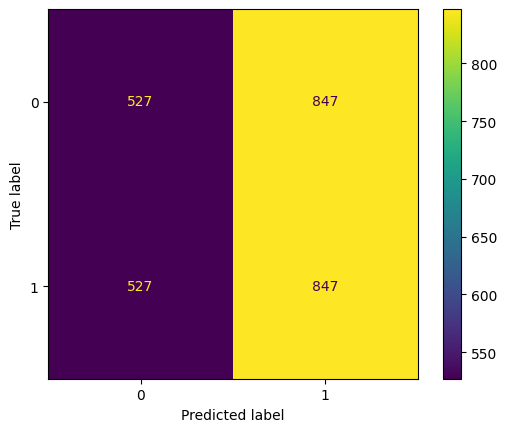

In [140]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf1 = confusion_matrix(y_test, preds)#, normalize='pred')
ConfusionMatrixDisplay(conf1).plot()